# PISCES wavelength calibration

We have PISCES VARIA calibration sets. We will show how to process them to build a new wavelength calibration

In [1]:
import numpy as np
import glob
from astropy.io import fits
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times',size=20)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=20)
plt.rc('image',origin='lower',interpolation='nearest')

import sys
import os

Populating the interactive namespace from numpy and matplotlib


### Import crispy-related stuff

In [2]:
os.chdir('/Users/mrizzo/IFS/crispy/crispy/PISCES/')

import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('crispy')
from crispy.tools.image import Image
from params import Params
par = Params()
par.hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

In [3]:
print par.wavecalDir

..//ReferenceFiles/Calibra_170425/


## Build wavelength calibration files

In [4]:
# We need to run the calibration for the first time
from crispy.tools.wavecal import buildcalibrations
par.gaussian_hires=False # since par.gaussian_hires is False, it will attempt to make high-resolution PSFLets
par.lamlist = np.arange(605.,730.,10)
par.filelist = [par.wavecalDir+'det'+str(wav)+'.fits' for wav in par.lamlist]
buildcalibrations(par,
                    inspect=False,
                    inspect_first=False,
                    genwavelengthsol=True, # Compute wavelength at the center of all pixels
                    makehiresPSFlets=True, # this requires very high SNR on the monochromatic frames
                    makePolychrome=True,   # This is needed to use least squares extraction
                    makePSFWidths=True,    # Fit PSF widths from high-res PSFLet models
                    upsample=3,            # upsampling factor of the high-resolution PSFLets
                    nsubarr=4,             # the detector is divided into nsubarr^2 regions for PSFLet averaging
                    apodize=False,          # to match PSFlet spot locations, only use the inner circular part of the 
                                           #detector, hence discarding the corners of the detector where lenslets are 
                                           #distorted
                    finecal=True,
                    trimfrac=0.0,
                  ) 

crispy - INFO - Building calibration files, placing results in ..//ReferenceFiles/Calibra_170425/
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det605.0.fits
crispy - INFO - Implementing experimental fine calibration method - watch out for bugs!
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det605.0.fits
crispy - INFO - Mean, median, std: (1.7852975606661181, 1.6666666, 4.5486891138405223)
crispy - INFO - Initializing PSFlet location transformation coefficients
crispy - INFO - Performing initial optimization of PSFlet location transformation coefficients for frame ..//ReferenceFiles/Calibra_170425/det605.0.fits
crispy - INFO - Array origin: (527.50655119890325, 514.91290760048366)
crispy - INFO - Performing final optimization of PSFlet location transformation coefficients for frame ..//ReferenceFiles/Calibra_170425/det605.0.fits
crispy - INFO - Array origin: (527.48566231222105, 515.00559834994999)
crispy - INFO - Finding individu

In [5]:
#par.lamlist = np.arange(615.,720.,10)

from crispy.tools.reduction import calculateWaveList
lam_midpts,lam_endpts = calculateWaveList(par,method='lstsq')
print('Wavelengths at midpoints for lstsq (nm): ',lam_midpts)
print('Wavelengths at endpoints for lstsq (nm): ',lam_endpts)
lam_midpts,lam_endpts = calculateWaveList(par,method='optext')
print('Wavelengths at midpoints for optext (nm): ',lam_midpts)
print('Wavelengths at endpoints for optext (nm): ',lam_endpts)

crispy - INFO - Reduced cube will have 25 wavelength bins
('Wavelengths at midpoints for lstsq (nm): ', array([ 607.19337906,  611.60402176,  616.04670331,  620.52165641,
        625.0291155 ,  629.56931671,  634.14249785,  638.74889851,
        643.38875999,  648.06232535,  652.76983941,  657.51154877,
        662.28770183,  667.09854879,  671.94434166,  676.8253343 ,
        681.74178238,  686.69394346,  691.68207695,  696.70644417,
        701.7673083 ,  706.86493447,  711.99958972,  717.17154301,
        722.38106529]))
('Wavelengths at endpoints for lstsq (nm): ', array([ 605.        ,  609.39471004,  613.82134317,  618.2801313 ,
        622.77130799,  627.29510852,  631.85176985,  636.4415307 ,
        641.0646315 ,  645.72131443,  650.41182342,  655.13640419,
        659.89530425,  664.68877287,  669.51706117,  674.38042207,
        679.27911035,  684.21338262,  689.18349737,  694.18971494,
        699.2322976 ,  704.31150949,  709.4276167 ,  714.58088722,
        719.77159102, 

## Monochromatic updates

## Construct new flatfield from monochromatic wavelengths

In [3]:
par.lamlist = np.arange(605.,730.,10)
par.filelist = [par.wavecalDir+'det'+str(wav)+'.fits' for wav in par.lamlist]
data = fits.getdata(par.filelist[0])
for i in range(1,len(par.filelist)-1):
    data += fits.getdata(par.filelist[i])
out = fits.HDUList(fits.PrimaryHDU(data.astype(np.float32)))
out.writeto('/Users/mrizzo/Downloads/newflat.fits',overwrite=True)


In [5]:
from crispy.IFS import reduceIFSMap
from crispy.tools.image import Image
cube = reduceIFSMap(par,'/Users/mrizzo/Downloads/newflat.fits',method='optext',smoothbad=False,medsub=False)
pixnoise=30
cube = reduceIFSMap(par,'/Users/mrizzo/Downloads/newflat.fits',method='lstsq',
                    fitbkgnd=True,
                    smoothbad=False,
                    niter=1,
                    dy=3,
                    medsub=False,
                    pixnoise=pixnoise,
                    gain=1,
                    normpsflets=False
                   )


crispy - INFO - Read data from HDU 0 of /Users/mrizzo/Downloads/newflat.fits
crispy - INFO - Mean, median, std: (127.17470182315884, 90.333336, 108.21849922491968)
crispy - INFO - Reduced cube will have 25 wavelength bins
crispy - INFO - Elapsed time: 2.769308s
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/Downloads/newflat.fits
crispy - INFO - Mean, median, std: (127.17470182315884, 90.333336, 108.21849922491968)
crispy - INFO - Reduced cube will have 25 wavelength bins
crispy - INFO - Adding an extra flat component to fit, N=26
crispy - INFO - Writing data to ..//SimResults/newflat_red_lstsq_resid.fits
crispy - INFO - Writing data to ..//SimResults/newflat_red_lstsq_model.fits
crispy - INFO - Writing data to ..//SimResults/newflat_red_lstsq_offsets.fits
crispy - INFO - Elapsed time: 21.530742s


In [7]:
cube = reduceIFSMap(par,par.filelist[6],method='lstsq',
                    fitbkgnd=True,
                    smoothbad=False,
                    niter=1,
                    dy=3,
                    medsub=False,
                    pixnoise=pixnoise,
                    gain=1,
                    normpsflets=False
                   )
cube = reduceIFSMap(par,par.filelist[6],method='optext',smoothbad=False,medsub=False)


crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det665.0.fits
crispy - INFO - Mean, median, std: (2.2303744686391718, 2.0, 4.745559854717321)
crispy - INFO - Reduced cube will have 25 wavelength bins
crispy - INFO - Adding an extra flat component to fit, N=26
crispy - INFO - Writing data to ..//SimResults/det665_red_lstsq_resid.fits
crispy - INFO - Writing data to ..//SimResults/det665_red_lstsq_model.fits
crispy - INFO - Writing data to ..//SimResults/det665_red_lstsq_offsets.fits
crispy - INFO - Elapsed time: 20.696893s
crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425/det665.0.fits
crispy - INFO - Mean, median, std: (2.2303744686391718, 2.0, 4.745559854717321)
crispy - INFO - Reduced cube will have 25 wavelength bins
crispy - INFO - Elapsed time: 2.347770s


# Construct lenslet bad pixel/flatfield from broadband reduced cube

The following only works if the reduced cube is first done WITHOUT already correcting for lenslet flatfield. To do this, run the but only AFTER running deleting the keywords in the parameters class:

In [ ]:
from crispy.IFS import reduceIFSMap

if hasattr(par,'lenslet_flat'): del par.lenslet_flat
if hasattr(par,'lenslet_mask'): del par.lenslet_mask
cube = reduceIFSMap(par,par.codeRoot+"/Inputs/BB.fits",method='lstsq',smoothbad=False)
# cubeOpt = reduceIFSMap(par,par.codeRoot+"/Inputs/BB.fits",method='optext',smoothbad=False)


In [ ]:
from crispy.tools.imgtools import gen_lenslet_flat
BBcube = Image(par.exportDir+"/BB_red_lstsq.fits")
lenslet_flat,lenslet_mask = gen_lenslet_flat(BBcube)
Image(data = lenslet_flat).write(par.exportDir+"/lenslet_flat.fits",clobber=True)
Image(data = lenslet_mask).write(par.exportDir+"/lenslet_mask.fits",clobber=True)
plt.figure(figsize=(10,10))
plt.imshow(lenslet_flat*lenslet_mask, cmap='viridis',vmin=0.8,vmax=1.2)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()


In [ ]:
psflets = Image(par.wavecalDir+"/hires_psflets_lam715.fits").data
fig, axarr = plt.subplots(4,4,figsize=(12,12))
for i in range(psflets.shape[0]):
    for j in range(psflets.shape[1]):
        axarr[i,j].imshow(psflets[i,j],vmin=0.0)
        axarr[i,j].axis('off')
plt.subplots_adjust(wspace=0.0,hspace=0.05)
plt.savefig(par.wavecalDir+"psflets.png")        
plt.show()


If you are satisfied with the flatfielding and masking, move the two fits files into the wavecal directory and reduce things with the two class attributes defined. When you reload the parameter file, the two attributes automatically get reset.

# Extract individual microspectrum

In [5]:
from crispy.IFS import reduceIFSMap
from crispy.tools.image import Image
from crispy.unitTests import testFitCutout, testCutout
from crispy.tools.reduction import get_cutout

In [6]:
BBimg = fits.getdata(par.codeRoot+"/Inputs/BB.fits")

# BBimg -= 30
# pixnoise = 30
# lensX = -20
# lensY = -20
# subim, psflet_subarr, [x0, x1, y0, y1] = testCutout(par,BBimg,lensX = lensX,lensY = lensY,dy=2.5)
# print subim[:,0]
cube = reduceIFSMap(par,BBimg,method='optext',smoothbad=False,medsub=False)


# coef, icov, model, chi2 = testFitCutout(par,BBimg,lensX,lensY,mode='lstsq_conv',pixnoise=pixnoise,dy=2.5)
# cube = reduceIFSMap(par,BBimg,method='lstsq_conv',
#                     fitbkgnd=False,
#                     smoothbad=False,
#                     niter=3,
#                     dy=3,
#                     medsub=False,
#                     pixnoise=pixnoise,
#                     gain=1,
#                     normpsflets=False
#                    )

crispy - INFO - Mean, median, std: (200.2881662824083, 131.0, 173.54631516876236)
crispy - INFO - Reduced cube will have 22 wavelength bins
crispy - INFO - Elapsed time: 2.540345s


[ -6.   1.  47.  45.  10.]


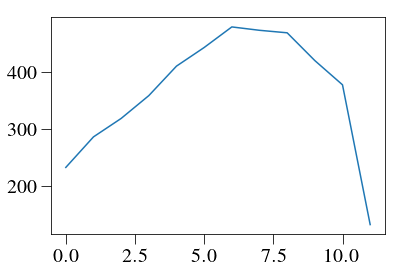

In [8]:
# coef = cube.data[:,108/2+lensY,108/2+lensX]
plt.plot(coef)
subim, psflet_subarr, [x0, x1, y0, y1] = testCutout(par,BBimg,lensX = lensX,lensY = lensY)
print subim[:,0]

[ 221.02784432  284.17334253  292.56973246  350.11430534  432.27898135
  440.04938073  452.84236845  450.9149687   451.82870219  401.75324238
  380.34418904  132.23705501]


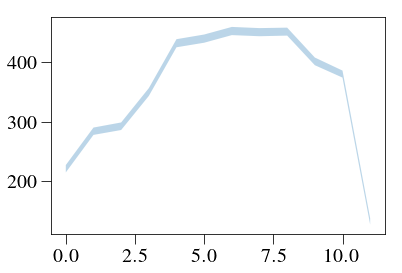

In [78]:
# plt.plot(coef)
plt.fill_between(np.arange(len(coef)), coef-np.sqrt(1./icov), coef+np.sqrt(1./icov),alpha=0.3)
print coef

Text(0.5,1,u'Residual image')

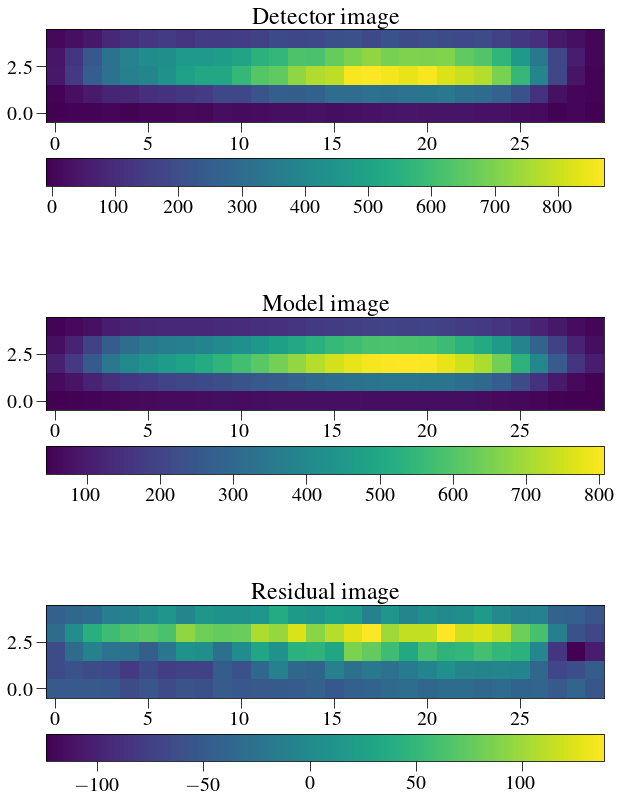

In [9]:
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.imshow(subim)
plt.colorbar(orientation='horizontal')
plt.title('Detector image')
plt.subplot(312)
plt.imshow(model)
plt.colorbar(orientation='horizontal')
plt.title('Model image')
plt.subplot(313)
res = subim-model
plt.imshow(res)
plt.colorbar(orientation='horizontal')
plt.title('Residual image')


40641.0 40877.077831 [ -6.   1.  47.  45.  10.]


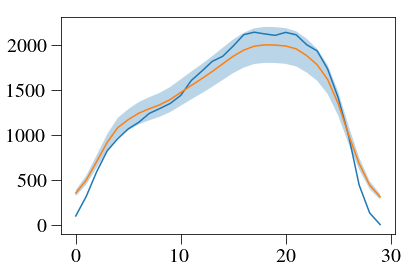

In [8]:
plt.plot(np.sum(subim,axis=0))
# plt.plot(cube.data[:,108/2+lensY,108/2+lensX])

plt.plot(np.sum(model,axis=0))
plt.fill_between(np.arange(subim.shape[-1]),0.9*np.sum(model,axis=0),1.1*np.sum(model,axis=0),alpha=0.3)
print np.sum(subim),np.sum(model),subim[:,0]

### Test Horne extraction

crispy - INFO - Reduced cube will have 22 wavelength bins
-0.180460812398


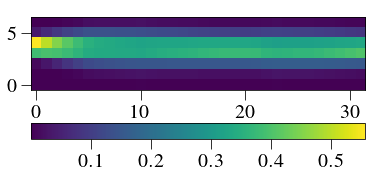

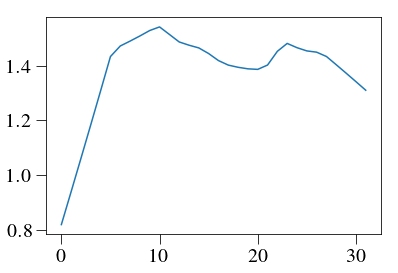

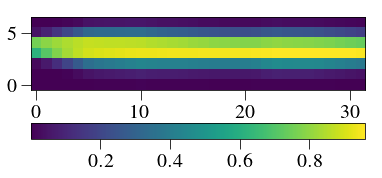

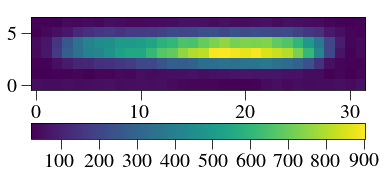

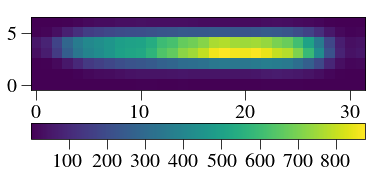

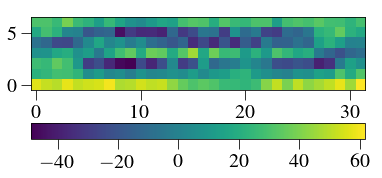

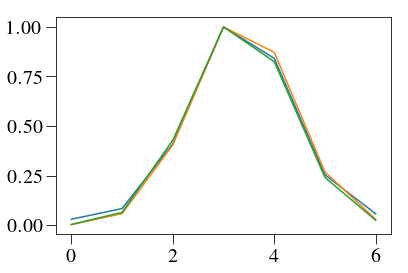

In [17]:
from crispy.tools.locate_psflets import PSFLets
from crispy.tools.reduction import calculateWaveList
PSFlet_tool = PSFLets(load=True, infiledir=par.wavecalDir)
#Nspec = int(par.BW*par.npixperdlam*par.R)
lamlist, scratch = calculateWaveList(par, method='optext')


img = fits.getdata(par.codeRoot+"/Inputs/BB.fits")
# img-=30
delt_y=7
xindx = PSFlet_tool.xindx
yindx = PSFlet_tool.yindx
Nmax = PSFlet_tool.nlam_max
try:
    sig = fits.open(par.wavecalDir + 'PSFwidths.fits')[0].data
except BaseException:
    log.warning(
        "No PSFLet widths found - assuming critical samping at central wavelength")
    sig = par.FWHM / 2.35 * np.ones(xindx.shape)
#     sig = 1.8 / 2.35 * np.ones(xindx.shape)

x = np.arange(img.shape[1])
y = np.arange(img.shape[0])
x, y = np.meshgrid(x, y)

ydim, xdim = img.shape

coefs = np.zeros(
    tuple([max(Nmax, lamlist.shape[0])] + list(yindx.shape)[:-1]))
cube = np.zeros((len(lamlist), par.nlens, par.nlens))
ivarcube = np.zeros((len(lamlist), par.nlens, par.nlens))
xarr, yarr = np.meshgrid(np.arange(Nmax), np.arange(delt_y))

#loglam = np.log(lamlist)
lamsol = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 0]
allcoef = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 1:]
PSFlet_tool.geninterparray(lamsol, allcoef)

good = PSFlet_tool.good

for i in range(xindx.shape[0]):
    for j in range(yindx.shape[1]):
        if i==108/2+lensY and j==108/2+lensX:
            if good[i, j]:
                _x = xindx[i, j, :PSFlet_tool.nlam[i, j]]
                _y = yindx[i, j, :PSFlet_tool.nlam[i, j]]
                _sig = sig[i, j, :PSFlet_tool.nlam[i, j]]
                _lam = PSFlet_tool.lam_indx[i, j, :PSFlet_tool.nlam[i, j]]
                iy = np.nanmean(_y)
                
                if ~np.isnan(iy):
                    i1 = int(iy - delt_y / 2.)+1
                    dy = _y[xarr[:,
                                 :len(_lam)]] - y[i1:i1 + delt_y,
                                                  int(_x[0]):int(_x[-1]) + 1]
                    lams, _ = np.meshgrid(_lam, np.arange(delt_y))

                    data = img[i1:i1 + delt_y, int(_x[0]):int(_x[-1]) + 1]
                    vals = np.sum(data,axis=1)
                    offset = np.sum(vals*np.arange(-delt_y/2.,delt_y/2.))/np.sum(vals)
                    print offset
                    offsets = fits.getdata('/Users/mrizzo/Downloads/newyoffsets.fits')
                    weight = np.exp(-(dy+offsets[i,j])**2 / _sig**2)
#                     weight = np.exp(-(dy)**2 / _sig**2)
                    weight /= np.sum(weight,axis=0)[np.newaxis,:]

                    ivar = np.ones(data.shape)

                    coefs[:len(_lam), i, j] = np.sum(
                        weight * data * ivar, axis=0)
                    coefs[:len(_lam), i, j] /= np.sum(weight**2 * ivar, axis=0)
                    vals = coefs[:len(_lam), i, j]
                    mod = vals[np.newaxis,:]*weight

plt.figure()
plt.imshow(weight)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.plot(_sig)
plt.figure()
offweight = np.exp(-(dy-offset)**2 / _sig**2)
plt.imshow(offweight)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.imshow(data)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.imshow(mod)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.imshow(data-mod)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.plot(data[:,20]/np.amax(data[:,20]))
plt.plot(weight[:,20]/np.amax(weight[:,20]))
plt.plot(offweight[:,20]/np.amax(offweight[:,20]))

[   94.98637602   173.0772245    387.28593733   693.03561871   954.64568546
  1156.34367199  1256.61221426  1349.27786105  1473.63577532  1528.49340974
  1567.63338143  1669.03097426  1826.79599177  1894.98996328  2038.3793841
  2078.78705163  2164.63370492  2300.6355561   2335.4628204   2280.33262064
  2265.96094537  2313.26635321  2315.60643928  2224.20109708  2141.22769745
  1926.06171689  1600.30653409  1145.7866641    584.53937213   228.29579059
   109.22070764   130.87711459]


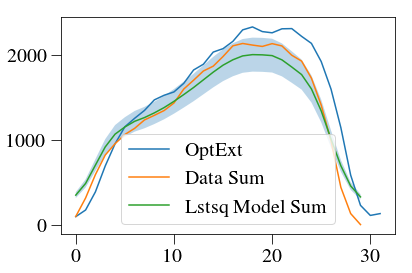

In [18]:
dat = coefs[:,108/2+lensX,108/2+lensY]
plt.plot(dat,label='OptExt')
print dat
# plt.plot(cube.data[:,108/2+lensY,108/2+lensX])

plt.plot(np.sum(subim,axis=0),label='Data Sum')
plt.plot(np.sum(model,axis=0),label='Lstsq Model Sum')
plt.legend()
plt.fill_between(np.arange(subim.shape[-1]),0.9*np.sum(model,axis=0),1.1*np.sum(model,axis=0),alpha=0.3)


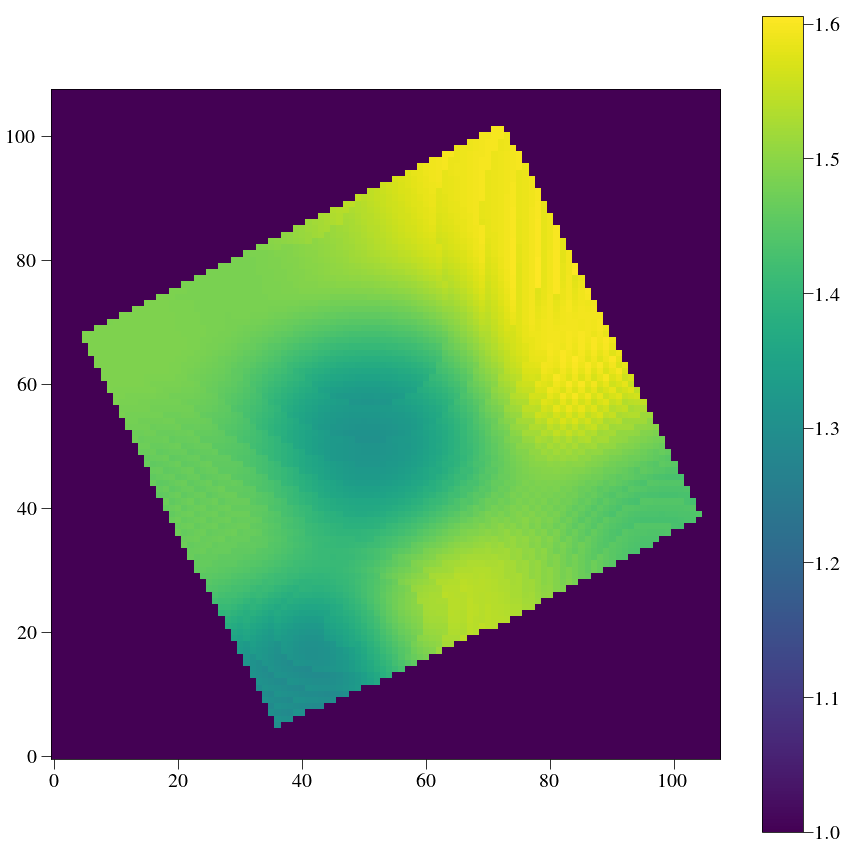

In [11]:
sig = fits.open(par.wavecalDir + 'PSFwidths.fits')[0].data
plt.figure(figsize=(15,15))
plt.imshow(sig[:,:,25])
plt.colorbar()

(4, 4, 42, 42)
1.44665264083


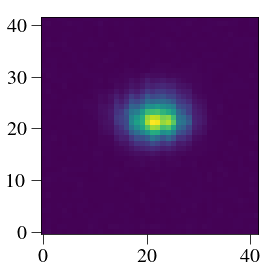

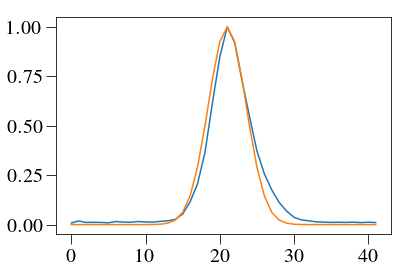

In [12]:
import glob
hireslist = glob.glob(par.wavecalDir + 'hires_psflets_lam???.fits')
hires = fits.getdata(hireslist[5])
print hires.shape
single = hires[2,2]
plt.imshow(single)
_x = np.arange(42) / 3.
_x -= _x[_x.shape[0] // 2]
row = np.sum(single[:,21:24],axis=1)
print np.sqrt(np.sum(row*_x**2)/np.sum(row))
plt.figure()
plt.plot(row/np.amax(row))
plt.plot(np.exp(-(_x**2)/1.44))

### Explore recovered Horne extraction single wavelength

In [13]:
cube = reduceIFSMap(par,par.wavecalDir+"/det655.0.fits",method='optext',smoothbad=False,medsub=True)
from crispy.tools.reduction import calculateWaveList
lam_midpts,_ = calculateWaveList(par,method='optext')
print lam_midpts

crispy - INFO - Read data from HDU 1 of ..//ReferenceFiles/Calibra_170425//det655.0.fits
crispy - INFO - Mean, median, std: (2.125893796982488, 2.0, 4.7077294794403182)
crispy - INFO - Subtracting median from image
crispy - INFO - Reduced cube will have 22 wavelength bins
crispy - INFO - Elapsed time: 2.842944s
crispy - INFO - Reduced cube will have 22 wavelength bins
[ 607.49309167  612.51013804  617.56861821  622.66887439  627.81125157
  632.99609763  638.22376328  643.49460217  648.80897084  654.1672288
  659.56973849  665.01686539  670.50897797  676.04644774  681.62964929
  687.25896031  692.9347616   698.65743709  704.42737391  710.24496236
  716.11059599  722.02467158]


#### Calculate the centroid of the wavelength in the cube

In [14]:
centroids = np.nansum(lam_midpts[:,np.newaxis,np.newaxis]*cube.data,axis=0)/np.nansum(cube.data,axis=0)

In [15]:
out = fits.HDUList(fits.PrimaryHDU(centroids.astype(np.float32)))
out.writeto('/Users/mrizzo/Downloads/centroids.fits',overwrite=True)


In [16]:
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(centroids, sigma=3.0, iters=5)
print mean, median, std

653.765618517 653.767558392 1.48383745298


In [12]:
yoffsets = fits.getdata(par.wavecalDir + 'dylistarr.fits')
print yoffsets[:,54+lensX,54+lensY]
print np.mean(yoffsets[:,54+lensX,54+lensY])

[-0.22587489 -0.09392428 -0.05733319 -0.08145154 -0.05622511 -0.02668447
 -0.1862385  -0.19920461 -0.14987439 -0.08838706 -0.02319758 -0.04660868
 -0.02917538]
-0.0972446


## Detail on smoothed least squares extraction

In [6]:
from crispy.tools.reduction import get_cutout,fit_cutout
polychromeR = fits.open(
                par.wavecalDir +
                'polychromeR%d.fits.gz' %
                (par.R))
psflets = polychromeR[0].data
polychromekey = fits.open(
    par.wavecalDir +
    'polychromekeyR%d.fits' %
    (par.R))
xindx = polychromekey[1].data
yindx = polychromekey[2].data
good = polychromekey[3].data
ifsimage = Image(par.codeRoot+"/Inputs/BB.fits")



model = np.zeros(ifsimage.data.shape)
resid = ifsimage.data.copy()

from crispy.tools.reduction import _add_row
i=54
j=54
normpsflets=False
dy=3

psflets = _add_row(psflets, n=1, dtype=np.float64)
psflets[-1:] = 0
psflets[-1, 4:-4, 4:-4] = 1
cube = np.zeros((psflets.shape[0], par.nlens, par.nlens))
ivarcube = np.zeros((psflets.shape[0], par.nlens, par.nlens))

subim, psflet_subarr, [y0, y1, x0, x1] = get_cutout(
    ifsimage, xindx[:, i, j], yindx[:, i, j], psflets, dy, normpsflets=normpsflets)


crispy - INFO - Read data from HDU 1 of ..//Inputs/BB.fits


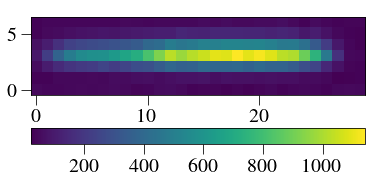

In [13]:
plt.imshow(subim)
plt.colorbar(orientation='horizontal')

(13, 7, 30)


NameError: name 'chi2ij' is not defined

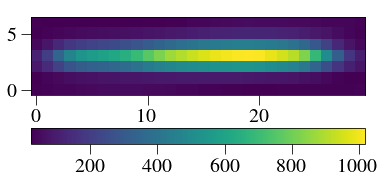

In [7]:
print psflet_subarr.shape

cube[:, j, i], ivarcube[:, j, i], modelij = fit_cutout(
    subim.copy(), psflet_subarr.copy(), mode='lstsq',
    niter=3, pixnoise=10.0,fitbkgnd=True)
plt.imshow(modelij)
plt.colorbar(orientation='horizontal')


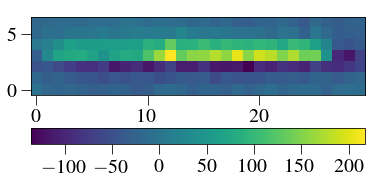

In [6]:
plt.imshow(subim-modelij)
plt.colorbar(orientation='horizontal')

### Explore moments

(7,)
[-3. -2. -1.  0.  1.  2.  3.]
0.107392175472


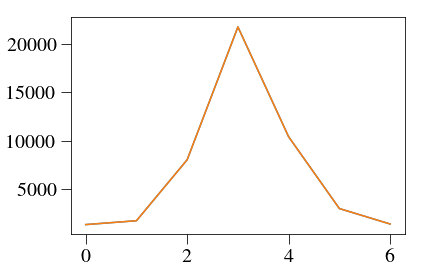

In [50]:
res = np.sum(subim,axis=1)#np.sum(subim-modelij,axis=1)#
plt.plot(res)
print res.shape
xlist = np.arange(min(res.shape),dtype=float)
xlist -= min(res.shape)/2.0 - 0.5
print xlist
momx = np.sum(xlist*res)/np.sum(res)
print momx
plt.plot(res)

### Smooth the least square step

In [85]:
import scipy as sp
from crispy.tools.reduction import _add_row
i=54
j=54
normpsflets=False
dy=3
polychromeR = fits.open(
                par.wavecalDir +
                'polychromeR%d.fits.gz' %
                (par.R))
psflets = polychromeR[0].data

subim, psflet_subarr, [y0, y1, x0, x1] = get_cutout(
    ifsimage, xindx[:, i, j], yindx[:, i, j], psflets, dy, normpsflets=normpsflets)


subim_flat = np.reshape(subim, -1)

pixnoise=0.0

psflets = _add_row(psflets, n=1, dtype=np.float64)
psflets[-1:] = 0
psflets[-1, 4:-4, 4:-4] = 1

subim, psflet_subarr, [y0, y1, x0, x1] = get_cutout(
    ifsimage, xindx[:, i, j], yindx[:, i, j], psflets, dy, normpsflets=normpsflets)


N = psflet_subarr.shape[0]
print N
psflets_flat = np.reshape(psflet_subarr, (N, -1))
A = psflets_flat.T



guess = np.ones(N) * np.sum(subim_flat) / float(N)
var = np.reshape(
    np.sum(psflet_subarr * guess[:, np.newaxis, np.newaxis], axis=0), -1)
Ninv = np.diag(1. / (var + 1e-10))
Cinv = np.dot(A.T, np.dot(Ninv, A))
C = np.linalg.inv(Cinv)
right = np.dot(A.T, np.dot(Ninv, subim_flat))
f = np.dot(C, right)
forig = f.copy()
bkgd = f[-1]
model_no_smooth = np.sum(psflet_subarr * f[:, np.newaxis, np.newaxis], axis=0)
print bkgd
psflets = psflets[:-1]


subim, psflet_subarr, [y0, y1, x0, x1] = get_cutout(
    ifsimage, xindx[:, i, j], yindx[:, i, j], psflets, dy, normpsflets=normpsflets)


N = psflet_subarr.shape[0]

psflets_flat = np.reshape(psflet_subarr, (N, -1))
A = psflets_flat.T

guess = np.ones(N) * np.sum(subim_flat) / float(N)
# var = np.reshape(
#     np.sum(psflet_subarr * guess[:, np.newaxis, np.newaxis], axis=0), -1)
# Ninv = np.diag(1. / (var + 1e-10))
# Cinv = np.dot(A.T, np.dot(Ninv, A))
# C = np.linalg.inv(Cinv)
# right = np.dot(A.T, np.dot(Ninv, subim_flat))
# f = np.dot(C, right)

# Q = sp.linalg.sqrtm(Cinv)
# s = np.sum(Q, axis=0)
# ivarlstsq = s**2  # inverse variance
# R = Q / s[:, np.newaxis]
# coef = np.dot(R, f)

niter = 1
for k in range(niter):
    print k
    var = np.reshape(
        np.sum(psflet_subarr * guess[:, np.newaxis, np.newaxis], axis=0), -1)
    Ninv = np.diag(1. / (var + 1e-10))
    Cinv = np.dot(A.T, np.dot(Ninv, A))
    C = np.linalg.inv(Cinv)
    Q = sp.linalg.sqrtm(Cinv)
    s = np.sum(Q, axis=1)
    ivarlstsq = s**2  # inverse variance
    R = Q / s[np.newaxis,:]
    newR = R.copy()
    for m in range(R.shape[1]):
        newR[m,:] = R[m,:]
        newsum = newR[m,:]<0.1
        newR[m,:][newsum] = 0.0
        newR[m,:] /= np.sum(newR[m,:])

    right = np.dot(A.T, np.dot(Ninv, subim_flat))
    f = np.dot(C, right)
    model_before_smooth = np.sum(psflet_subarr * f[:, np.newaxis, np.newaxis], axis=0)
    guess = np.dot(newR, f)


# right = np.dot(A.T, np.dot(Ninv, subim_flat))
# f = np.dot(C, right)
# coef = f
coef = guess
icov = np.diagonal(C)
model = np.sum(psflet_subarr * coef[:, np.newaxis, np.newaxis], axis=0)+bkgd
chi2 = np.sum((subim-model)**2 / model) / np.prod(subim.shape)


13
-32.9321275129
0


### Smooth the least square step (attempt 2)

In [125]:
import scipy as sp
from crispy.tools.reduction import _add_row
i=54
j=54
normpsflets=False
dy=3
polychromeR = fits.open(
                par.wavecalDir +
                'polychromeR%d.fits.gz' %
                (par.R))
psflets = polychromeR[0].data

subim, psflet_subarr, [y0, y1, x0, x1] = get_cutout(
    ifsimage, xindx[:, i, j], yindx[:, i, j], psflets, dy, normpsflets=normpsflets)


subim_flat = np.reshape(subim, -1)

pixnoise=0.0

# calculate line spread function matrix
N = psflet_subarr.shape[0]
print N
psflets_flat = np.reshape(psflet_subarr, (N, -1))
A = psflets_flat.T
Cinv = np.dot(A.T, A)
C = np.linalg.inv(Cinv)
Q = sp.linalg.sqrtm(Cinv)
s = np.sum(Q, axis=1)
ivarlstsq = s**2  # inverse variance
R = Q / s[np.newaxis,:]
newR = np.zeros((R.shape[0]+1,R.shape[1]+1))
newR[:R.shape[0],:R.shape[1]] = R
newR[-1,-1] = 1


psflets = _add_row(psflets, n=1, dtype=np.float64)
psflets[-1:] = 0
psflets[-1, 4:-4, 4:-4] = 1

subim, psflet_subarr, [y0, y1, x0, x1] = get_cutout(
    ifsimage, xindx[:, i, j], yindx[:, i, j], psflets, dy, normpsflets=normpsflets)


N = psflet_subarr.shape[0]
print N
psflets_flat = np.reshape(psflet_subarr, (N, -1))
A = psflets_flat.T

guess = np.ones(N) * np.sum(subim_flat) / float(N)
var = np.reshape(
    np.sum(psflet_subarr * guess[:, np.newaxis, np.newaxis], axis=0), -1)
Ninv = np.diag(1. / (var + 1e-10))
Cinv = np.dot(A.T, np.dot(Ninv, A))
C = np.linalg.inv(Cinv)
# Q = sp.linalg.sqrtm(Cinv)
# s = np.sum(Q, axis=1)
# ivarlstsq = s**2  # inverse variance
# R = Q / s[np.newaxis,:]
right = np.dot(A.T, np.dot(Ninv, subim_flat))
f = np.dot(C, right)
bkgd = f[-1]
print bkgd

coefs = np.dot(newR,f)
# coefs = np.dot(R,f)
model_smooth = np.sum(psflet_subarr * coefs[:, np.newaxis, np.newaxis], axis=0)
# coefs = np.dot(R,f[:-1])
# model_smooth = np.sum(psflet_subarr[:-1,:,:] * coefs[:, np.newaxis, np.newaxis], axis=0)+f[-1]
model_no_smooth = np.sum(psflet_subarr * f[:, np.newaxis, np.newaxis], axis=0)



12
13
-32.9321275129


59.1677259646
55.0862272575


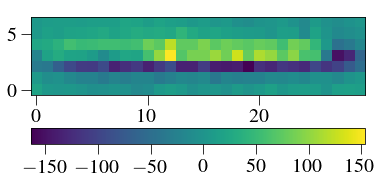

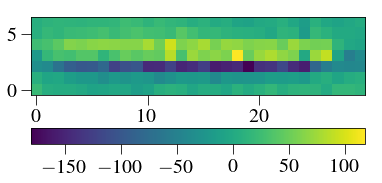

In [126]:
# plt.imshow(model_smooth-model_no_smooth)
plt.imshow(subim-model_smooth)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.imshow(subim-model_no_smooth)
plt.colorbar(orientation='horizontal')
print np.std(subim-model_smooth)
print np.std(subim-model_no_smooth)

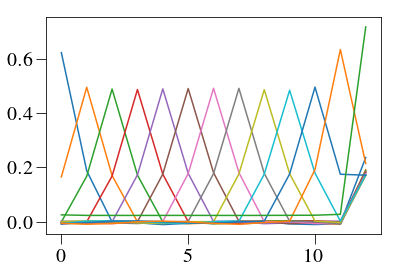

In [119]:
plt.plot(R)

In [132]:
Ctilde = np.dot(newR,np.dot(C,newR.T))
print np.sqrt(np.sum(Ctilde[5,:])),np.sqrt(Ctilde[5,5])
import pandas as pd
df = pd.DataFrame(data=Ctilde)
df

38.0734019444 29.2031133248


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1182.277561,108.182959,109.787350,89.454594,97.857430,90.348797,88.378590,86.463832,82.828894,89.326755,78.218981,112.704547,-84.887545
1,108.182959,910.138149,71.372286,53.219212,60.316241,58.567351,56.210857,53.272545,51.179906,56.303430,50.224791,74.970220,-57.039531
2,109.787350,71.372286,932.109203,63.315590,66.564565,63.274302,64.109377,62.125887,58.369438,62.840852,54.398628,85.575211,-62.012051
3,89.454594,53.219212,63.315590,889.392480,55.613657,56.987424,54.728560,55.353907,52.307031,56.960546,46.770110,76.409591,-56.041356
4,97.857430,60.316241,66.564565,55.613657,876.649851,53.582398,56.008935,54.644297,54.492668,57.788143,48.997803,73.920007,-56.686683
5,90.348797,58.567351,63.274302,56.987424,53.582398,852.821828,49.620186,52.346389,49.049314,57.210204,48.114352,72.636142,-54.974751
6,88.378590,56.210857,64.109377,54.728560,56.008935,49.620186,824.136062,48.140225,50.682488,51.167316,46.909498,68.553321,-53.269965
7,86.463832,53.272545,62.125887,55.353907,54.644297,52.346389,48.140225,787.692119,45.506955,51.108043,46.659028,71.234527,-51.685504
8,82.828894,51.179906,58.369438,52.307031,54.492668,49.049314,50.682488,45.506955,774.348976,46.356206,35.627060,64.173964,-49.772829
9,89.326755,56.303430,62.840852,56.960546,57.788143,57.210204,51.167316,51.108043,46.356206,769.097509,55.810988,75.726355,-53.709252


In [129]:
df = pd.DataFrame(data=C)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,4677.664491,-3806.501194,2460.621827,-1326.603501,947.157991,-415.721874,258.318655,-67.290158,65.099271,129.453941,57.519663,70.899407,-120.041501
1,-3806.501194,8285.844875,-6102.953296,3718.118795,-2240.919767,1367.285337,-687.316731,344.642665,-162.228592,-15.008586,28.175850,64.160594,-20.761665
2,2460.621827,-6102.953296,9750.549182,-6937.359509,4360.467892,-2540.085212,1536.184072,-709.541156,379.761735,-77.778147,-6.130327,109.953164,-85.160602
3,-1326.603501,3718.118795,-6937.359509,10146.688414,-7338.468918,4575.245680,-2667.892928,1556.043288,-788.229394,401.981335,-180.754767,77.732674,-41.847444
4,947.157991,-2240.919767,4360.467892,-7338.468918,10354.756869,-7467.150980,4616.238165,-2623.991646,1561.288701,-732.567822,367.639948,-88.370477,-63.235014
5,-415.721874,1367.285337,-2540.085212,4575.245680,-7467.150980,10297.190302,-7389.149223,4506.800899,-2611.390114,1495.815664,-661.034823,252.271685,-51.100795
6,258.318655,-687.316731,1536.184072,-2667.892928,4616.238165,-7389.149223,10007.345288,-7113.094692,4378.100017,-2442.603046,1263.886581,-367.730398,-50.006939
7,-67.290158,344.642665,-709.541156,1556.043288,-2623.991646,4506.800899,-7113.094692,9526.516347,-6803.452306,4068.690934,-2057.338494,806.231562,-53.741572
8,65.099271,-162.228592,379.761735,-788.229394,1561.288701,-2611.390114,4378.100017,-6803.452306,9225.906101,-6418.870364,3401.270058,-1171.382831,-34.822237
9,129.453941,-15.008586,-77.778147,401.981335,-732.567822,1495.815664,-2442.603046,4068.690934,-6418.870364,8694.473613,-5410.072204,2075.583450,-72.115897


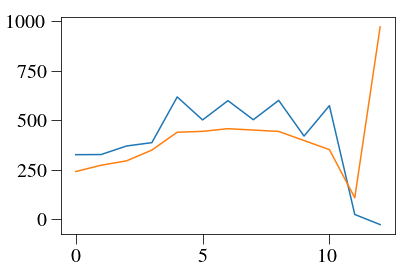

In [123]:
plt.plot(f)
plt.plot(coefs)

### line spread function matrix

12


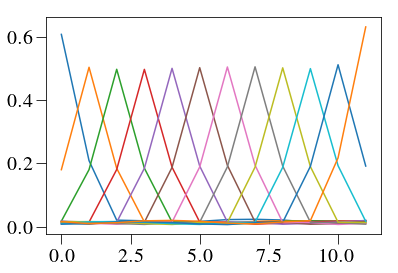

In [96]:
N = psflet_subarr.shape[0]
print N
psflets_flat = np.reshape(psflet_subarr, (N, -1))
A = psflets_flat.T
Cinv = np.dot(A.T, A)
C = np.linalg.inv(Cinv)
Q = sp.linalg.sqrtm(Cinv)
s = np.sum(Q, axis=1)
ivarlstsq = s**2  # inverse variance
R = Q / s[np.newaxis,:]
plt.plot(R)

1.0


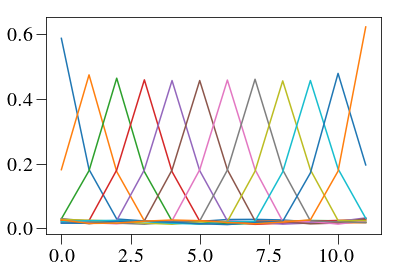

In [42]:
plt.plot(R)
print np.sum(R[:,5])

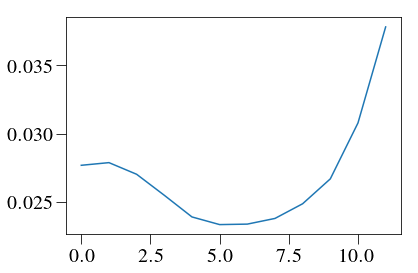

In [45]:
plt.plot(ivarlstsq)

[ 290.72312091  318.85056657  332.51685397  382.19495662  457.36452306
  460.23531222  473.29927973  466.1221938   465.52380834  418.90317993
  401.24926833  186.65341803]
[ 558.01327396  451.64081662  551.59432381] 460.235312219
460.235312219
[ 0.02079415  0.01263334  0.02035264  0.02176369  0.17784702  0.45682038
  0.18066625  0.02221564  0.01975821  0.01240306  0.01373625  0.02308719]


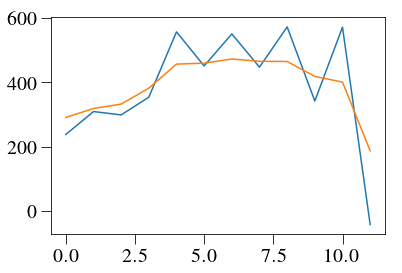

In [50]:
plt.plot(f)
plt.plot(coef)
print coef
print f[4:7],coef[5]
print np.sum(R[5,:]*f)
print R[5,:]

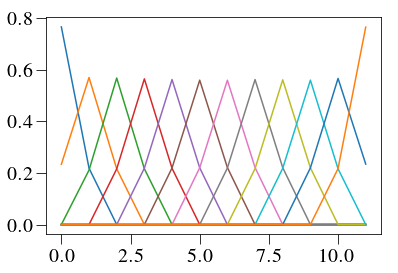

In [77]:
newR = R.copy()
for i in range(R.shape[1]):
    newR[i,:] = R[i,:]
    newsum = newR[i,:]<0.1
    newR[i,:][newsum] = 0.0
    newR[i,:] /= np.sum(newR[i,:])
plt.plot(newR)

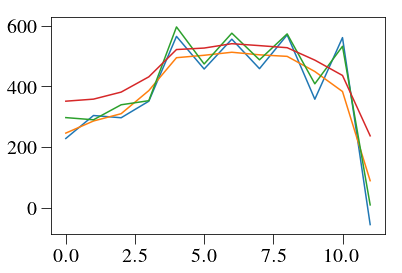

In [93]:
plt.plot(f)
plt.plot(np.dot(newR,f))
plt.plot(forig[:-1] + forig[-1])
plt.plot(np.dot(R,forig[:-1]))
newmodel = np.sum(psflet_subarr * np.dot(newR,f)[:, np.newaxis, np.newaxis], axis=0)+bkgd
oldmodel = np.sum(psflet_subarr * np.dot(R,forig[:-1])[:, np.newaxis, np.newaxis], axis=0)+bkgd

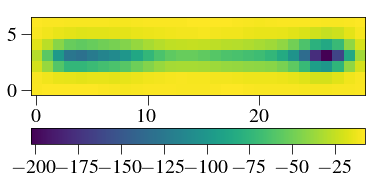

In [94]:
# plt.imshow(newmodel-model_no_smooth)
# plt.imshow(newmodel-model_before_smooth)
plt.imshow(newmodel-oldmodel)
plt.colorbar(orientation='horizontal')

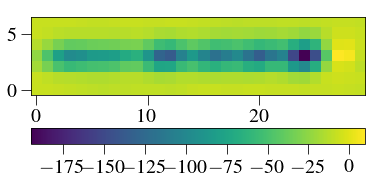

In [80]:
plt.imshow(model-model_no_smooth)
plt.colorbar(orientation='horizontal')

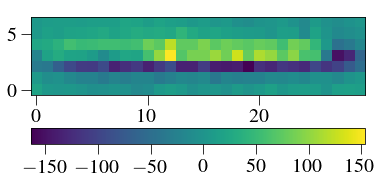

In [99]:
plt.imshow(subim-model_no_smooth)
plt.colorbar(orientation='horizontal')

65.1297387795


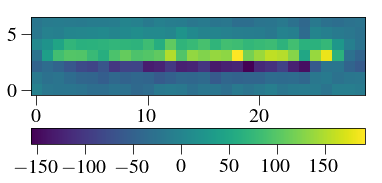

In [85]:
plt.imshow(subim-modelij)
print np.std(subim-modelij)
plt.colorbar(orientation='horizontal')

### Try full routine

In [14]:
from crispy.tools.reduction import lstsqExtract
ifsimage = Image(par.codeRoot+"/Inputs/BB.fits")
cube, model, resid = lstsqExtract(par, par.exportDir+'/test', ifsimage, smoothandmask=False, ivar=False, dy=3,
                 refine=False, hires=False, upsample=3, fitbkgnd=True,
                 specialPolychrome=None, returnall=True, mode='lstsq',
                 niter=3, pixnoise=10.0, normpsflets=False, gain=1.,
                 discard_constant=False)

crispy - INFO - Read data from HDU 1 of ..//Inputs/BB.fits
crispy - INFO - Adding an extra flat component to fit, N=13
crispy - INFO - Reduced cube will have 22 wavelength bins
crispy - INFO - Writing data to ..//SimResults/test_resid.fits
crispy - INFO - Writing data to ..//SimResults/test_model.fits


crispy - INFO - Read data from HDU 1 of ..//Inputs/BB.fits


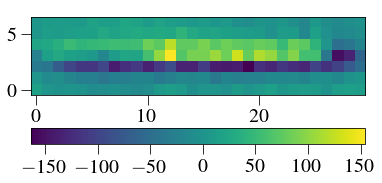

In [9]:
from crispy.tools.reduction import get_cutout
polychromeR = fits.open(
                par.wavecalDir +
                'polychromeR%d.fits.gz' %
                (par.R))
psflets = polychromeR[0].data
polychromekey = fits.open(
    par.wavecalDir +
    'polychromekeyR%d.fits' %
    (par.R))
xindx = polychromekey[1].data
yindx = polychromekey[2].data
good = polychromekey[3].data
ifsimage = Image(par.codeRoot+"/Inputs/BB.fits")
i=54
j=54
normpsflets=False
dy=3
subim, psflet_subarr, [y0, y1, x0, x1] = get_cutout(
    ifsimage, xindx[:, i, j], yindx[:, i, j], psflets, dy, normpsflets=normpsflets)
plt.imshow(subim-model[y0:y1, x0:x1])
plt.colorbar(orientation='horizontal')


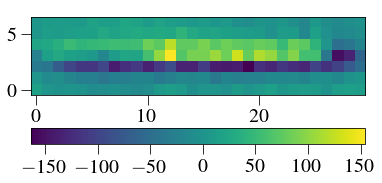

In [10]:
plt.imshow(resid[y0:y1, x0:x1])
plt.colorbar(orientation='horizontal')


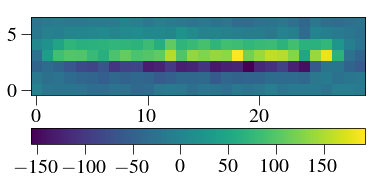

In [43]:
spec = cube.data[:,j,i]
plt.imshow(ifsimage.data[y0:y1, x0:x1]-np.sum(psflet_subarr*spec[:,np.newaxis,np.newaxis],axis=0))
plt.colorbar(orientation='horizontal')


In [13]:
print np.nanstd(fits.getdata(par.exportDir+'/test_resid.fits'))
print np.nanstd(fits.getdata(par.exportDir+'/BB_red_lstsq_resid.fits'))

91.7734
49.5676


## Plot with/without fine calibration for PISCES

(-0.5, 199.5, -0.5, 199.5)

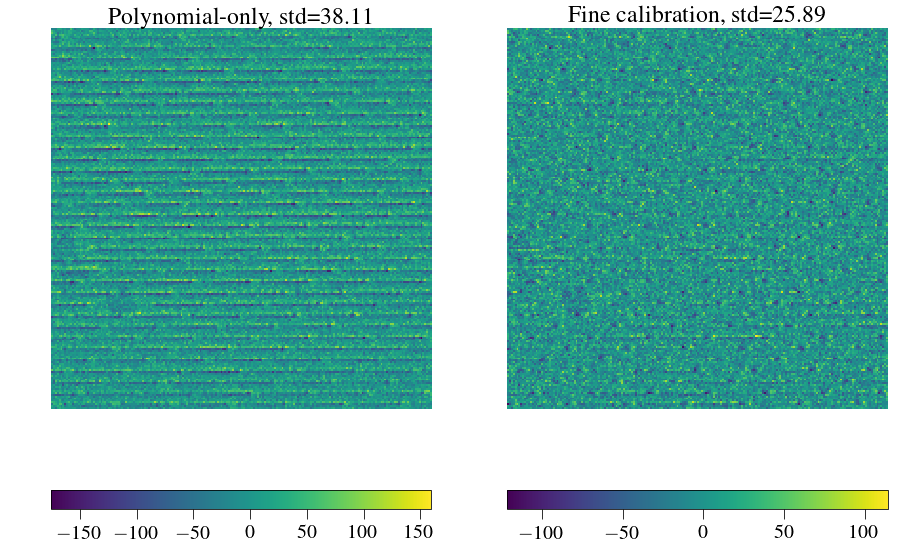

In [6]:
nofine = fits.getdata(par.exportDir+'/newflat_red_lstsq_resid_nofine.fits')
fine = fits.getdata(par.exportDir+'/newflat_red_lstsq_resid.fits')
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(nofine[600:800,400:600])
plt.colorbar(orientation='horizontal')
plt.title('Polynomial-only, std={:.2f}'.format(np.std(nofine[600:800,400:600])))
plt.axis('off')
plt.subplot(122)
plt.imshow(fine[600:800,400:600])
plt.colorbar(orientation='horizontal')
plt.title('Fine calibration, std={:.2f}'.format(np.std(fine[600:800,400:600])))
plt.axis('off')
